# Precompute results (skip for reading)

In this section, we precompute the results we want to display and store some of them, so they can be loaded later on. For more information on how the simulation works, refer to the `fresh_analysis.ipynb` notebook in the main directory.

In [1]:
# Display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact
from tqdm import tqdm, trange
from matplotlib import animation

# Numerics
import numpy as np
import jax
import jax.numpy as jnp

# Functional
from typing import List, Callable
from functools import partial

# Own
import sys
sys.path.append("..")
from data_gen_x import gen_data_x
from models import *

In [2]:
def style_plot(ax: plt.Axes, num_it: int) -> plt.Axes:
    """
    Generate style for Learning Rate plots.
    :param ax: Drawing axis
    :param num_it: Number of plotted iterations
    :return: axis
    """
    ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.legend()
    ax.hlines(50,0,num_it,color="silver", linestyles="--") 
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Correct trials (%)")
    ax.set_xlim((0, num_it))
    return ax

In [3]:
def simulation(
    seed: int,
    num_it: int = 2000,
    cond: Callable = an_cond,
    lr_sgd: float = 8e-3,
    lr_hebb: float = 5e-3,
):
    """
    Prepare test and validation data and run simulation.
    :param seed: Random PRNG seed
    :param num_it: Number of iterations to run
    :param cond: Function specifying if iteration i is an active or only passive trial.
    :param lr_sgd: SGD learning rate for v
    :param lr_hebb: Hebbian learning rate for v
    """
    jax_key = jax.random.PRNGKey(seed)

    # Prepare means of point clouds
    data_means = parclass_v().means 
    data_sigs = parclass_base(pancake_scale=1).sigs

    X_train, y_train, _ = gen_data_x(
        jax_key, 1000, 20, 2, data_sigs, data_means, vec=True
    )

    jax_key, subkey1, subkey2 = jax.random.split(jax_key, 3)
    X_val, y_val, _ = gen_data_x(
        subkey1, 1000, 20, 2, data_sigs, data_means, vec=True
    )

    sim_pars = parclass_v(
        lr_sgd_v=lr_sgd, lr_hebb_v=lr_hebb, lam_sgd_v=1e-2, lam_hebb_v=1
    )
    sim_pars.means = data_means

    test_single = OneLayer(subkey2, pars=sim_pars)
    test_single.run_scheme(cond, X_train, y_train, X_val, y_val, num_it)
    return test_single.metrics

In [4]:
def simulation_double(
    seed: int,
    num_it: int = 2000,
    cond: Callable = an_cond,
    lr_sgd_v: float = 0,
    lr_hebb_v: float = 1e-4,
    lr_sgd_w: float = 1e-3,
    lr_fsm_w: float = 2e-3,
    hebb_w: bool = False,
    debug: bool = False
):
    """
    Prepare test and validation data and run simulation.
    :param seed: Random PRNG seed
    :param num_it: Number of iterations to run
    :param cond: Function specifying if iteration i is an active or only passive trial.
    :param lr_sgd_v: SGD learning rate for v
    :param lr_hebb_v: Hebbian learning rate for v
    :param lr_sgd_w: SGD learning rate for W
    :param lr_fsm_w: FSM/Hebbian learning rate for W
    :param hebb_w: If True, use Hebbian learning for W, otherwise FSM
    """
    jax_key = jax.random.PRNGKey(seed)

    # Prepare means of point clouds
    data_means = parclass_wv().means 

    X_train, y_train, _ = gen_data_x(
        jax_key, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True
    )
    jax_key, subkey1, subkey2 = jax.random.split(jax_key, 3)
    X_val, y_val, _ = gen_data_x(
        subkey1, 1000, 20, 2, parclass_wv().sigs, data_means, vec=True
    )

    sim_pars = parclass_wv(
        lam_fsm_w=1,
        lam_sgd_w=1e-2,
        lam_hebb_v=1,
        lam_sgd_v=5e-2,
        lr_hebb_v=lr_hebb_v,
        lr_fsm_w=lr_fsm_w,
        lr_sgd_w=lr_sgd_w,
        lr_sgd_v=lr_sgd_v,
        hebb_w=hebb_w,
        lr_sgd_v_decay=0,
        debug=debug
    )
    sim_pars.means = data_means

    test_double = TwoLayer(subkey2, pars=sim_pars)
    test_double.run_scheme(cond, X_train, y_train, X_val, y_val, num_it)
    return test_double.metrics

One layer network simulations

In [5]:
an_onel = jax.vmap(lambda seed: simulation(seed, cond=an_cond, num_it=2000))(
    jnp.arange(100)
)
ap_onel = jax.vmap(lambda seed: simulation(seed, cond=ap_cond, num_it=20000))(
    jnp.arange(100)
)
pta_onel = jax.vmap(lambda seed: simulation(seed, cond=pta_cond, num_it=20000))(
    jnp.arange(100)
)

(2000,)
(20000,)
(20000,)


Two layer network simulations

In [13]:
#Unsupervised v, Supervised W
an_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=an_cond, num_it=4000, lr_sgd_v=0, lr_hebb_v=2e-3, lr_sgd_w=2e-3, lr_fsm_w=0, hebb_w=True))(jnp.arange(100))
ap_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=ap_cond, num_it=40000, lr_sgd_v=0, lr_hebb_v=2e-3, lr_sgd_w=2e-3, lr_fsm_w=0, hebb_w=True))(jnp.arange(100))
pta_doublel_sw = jax.vmap(lambda seed: simulation_double(seed, cond=pta_cond, num_it=40000, lr_sgd_v=0, lr_hebb_v=2e-3, lr_sgd_w=2e-3, lr_fsm_w=0, hebb_w=True))(jnp.arange(100))

(4000,)
(40000,)
(40000,)


In [10]:
#Functions to make videos
def get_pts_from_line(v, b):
    """Returns two points on the line v\dot x + b = 0."""
    v = np.array(v)
    norm_v = np.linalg.norm(v)
    if v[1] != 0:
        p1 = (+1, -(b + v[0]) / v[1] ) / norm_v
        p2 = (-1, -(b - v[0]) / v[1] ) / norm_v
    else:
        p1 = (b / v[0], 1) / norm_v
        p2 = (b / v[0], -1) / norm_v
    return (p1, p2)

xdata_plot, ydata_plot = [], []


def animate_sw(i):
    """Animation function for updates"""
    my_line_plot.set_offsets(plot_doublel[1][2][0][i])
    global my_axe
    my_axe.remove()
    my_axe = ax.axline(*get_pts_from_line(plot_doublel[1][4][0][i], 0), ls = '--')

(40000,)


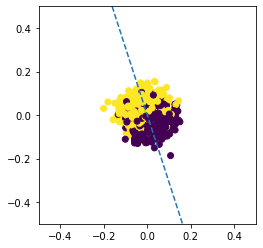

In [11]:
plot_doublel = jax.vmap(lambda x: simulation_double(x, cond=pta_cond, num_it=40000, lr_sgd_v=0, lr_hebb_v=2e-3, lr_sgd_w=2e-3, lr_fsm_w=0, hebb_w=True, debug=True))(jnp.arange(2,4))
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
my_line_plot = ax.scatter(*zip(*plot_doublel[1][2][0][0]), c=plot_doublel[1][3][0][0])
my_axe = ax.axline(*get_pts_from_line(plot_doublel[1][4][0][0], 0), ls = '--')
anim = animation.FuncAnimation(fig, animate_sw,
                                frames=range(0,len(plot_doublel[1][2][0]), 100), interval=100,repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
anim.save('vid/swuv.mp4', writer=writervideo)

In [5]:
#Unsupervised W, supervised v
an_doublel_sv = jax.vmap(lambda seed: simulation_double(seed, cond=an_cond, num_it=4000, lr_sgd_v=2e-2, lr_hebb_v=0, lr_sgd_w=0, lr_fsm_w=2e-2, hebb_w=True))(jnp.arange(100))
ap_doublel_sv = jax.vmap(lambda seed: simulation_double(seed, cond=ap_cond, num_it=40000, lr_sgd_v=2e-2, lr_hebb_v=0, lr_sgd_w=0, lr_fsm_w=2e-2, hebb_w=True))(jnp.arange(100))
pta_doublel_sv = jax.vmap(lambda seed: simulation_double(seed, cond=pta_cond, num_it=40000, lr_sgd_v=2e-2, lr_hebb_v=0, lr_sgd_w=0, lr_fsm_w=2e-2, hebb_w=True))(jnp.arange(100))

(4000,)
(40000,)
(40000,)


(40000,)


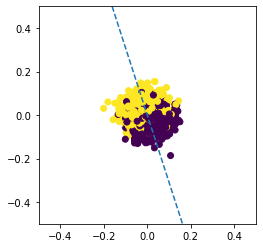

In [24]:
plot_doublel = jax.vmap(lambda x: simulation_double(x, cond=pta_cond, num_it=40000, lr_sgd_v=2e-2, lr_hebb_v=0, lr_sgd_w=0, lr_fsm_w=2e-2, hebb_w=True, debug=True))(jnp.arange(2,4))
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
my_line_plot = ax.scatter(*zip(*plot_doublel[1][2][0][0]), c=plot_doublel[1][3][0][0])
my_axe = ax.axline(*get_pts_from_line(plot_doublel[1][4][0][0], 0), ls = '--')
anim = animation.FuncAnimation(fig, animate_sw,
                                frames=range(0,len(plot_doublel[1][2][0]), 100), interval=100,repeat=False)
writervideo = animation.FFMpegWriter(fps=60)
anim.save('vid/svuw.mp4', writer=writervideo)

# Modelling for Sound Discrimination Task

## Task

We want to model a behavioural experiment where mice learn to discrimante pitch-up and pitch-down sounds in different learning settings. In order to build a simple machine learning model, we simplify the task as follows: We assume that the two different sounds are represented by abstract input points in a high dimensional space. To incorporate natural neuronal variability, we assume that the two inputs are drawn from two normal distributions $\mathcal{N}(\vec\mu_\pm, \Sigma)$.

For our initial simulations, we simply set
$$\Sigma = \sigma^2 \mathbf{1}, \quad \mu_\pm = \pm (a, 0, \ldots, 0),$$
where $\sigma=0.07$, $a=0.1$. We choose the dimension $d$ of our input to be 20.

Figure: Data distribution

## Learning schemes

We train our model with combinations of

- Active Learning: The model is provided with a sample and its label.
- Passive Learning: The model is provided with a passive sample. To reproduce the learning scheme of the experiment, we assume those passive samples are drawn from normal distributions with means on the line segment between $\vec \mu_+$ and $\vec \mu_-$ and covariance $\Sigma$.

This is combined into the following three training schemes:

- Active only: For all training sessions, the model is provided with a sample and its label.
- Active and Passive (A + P): Each active training session is followed by 9 passive sessions.
- Passive then Active (P : A): The first 90% of sessions are only passive, the last 10% are active.

In our simulations, we let each training scheme have the same total number of active sessions.

## One-layer model

<center>
<img src="img/vmodel.png">
</center>

In the one-layer model, the input $\vec x$ is multiplied by a weight vector $\vec v$ to produce an output $\sigma(\vec v \cdot \vec x)$, where $\sigma$ is the logistic sigmoid function. This model can be trained with
- Supervised Learning: The weight $\vec v$ undergoes ($\ell^2$-regularized) stochastic gradient descent with binary cross-entropy as the loss function; this is logistic regression.
- Unsupervised Learning: The weight $\vec v$ is trained with Hebbian learning with weight decay (Oja's rule).

## Two-layer model

<center><img src="img/vwmodel.png"  align="center"/></center>

In addition to the readout weight $\vec v$, the two layer model has an initial weight $W$ mapping the input $\vec x$ to a hidden representation $\vec y = W \vec x$. The output of the model is then $\sigma(\vec v \cdot W\vec x)$. For our simulations, the dimension of the hidden layer $d_\text{hid}$ is smaller than the input dimension $d$.

We can train $v$ using the same algorithms as above, and in addition, we have the option to train $W$ with
- Supervised Learning: The weight $W$ undergoes ($\ell^2$-regularized) stochastic gradient with a binary cross-entropy loss.
- Unsupervised Learning: The weight $W$ is trained with Hebbian learning with weight decay (Oja's rule). This learns the first principal component of the input data. We could use an extension of this algorithm to learn higher components (like Fast Similarity Matching by Pehlevan et al.)

# Results

## One-layer model

For the one-layer network, we can use either supervised learning for $\vec v$, unsupervised learning for $\vec v$, or both. A model with only unsupervised learning would never reliably learn the correct association between inputs and their labels, because of the problem's $\mathbb Z_2$ symmetry. Having only supervised learning could not explain the benefit of passive training sessions. Thus, both the unsupervised and the supervised learning rates in our model have to be non-zero.

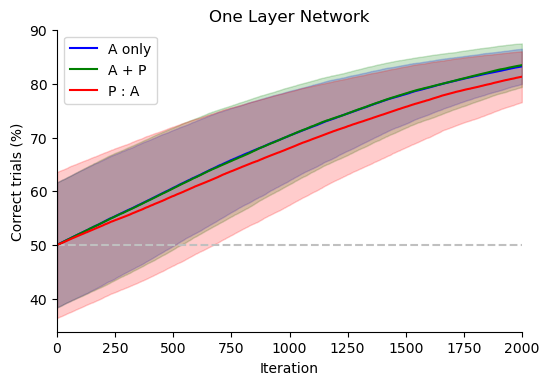

In [42]:
to_draw = [
    [an_onel[1][0], "A only", "blue"],
    [ap_onel[1][0][:, ::10], "A + P", "green"],
    [pta_onel[1][0][:, -2000:], "P : A", "red"],
]
fig, ax = plt.subplots(1,1)
for data, label, color in to_draw:
    data_mean = 100 * data.mean(axis=0)
    data_std = 100 * data.std(axis=0)
    ax.plot(data_mean, label=label, color=color)
    ax.fill_between(
        np.arange(len(data_mean)),
        data_mean - data_std,
        data_mean + data_std,
        alpha=0.2,
        color=color,
    )
ax = style_plot(ax, 2000)
ax.set_title("One Layer Network")
fig.set_dpi(100)
fig.show()

As we can see, there is no benefit to passive pre-exposure, and even the interleaved passive training sessions only help imperceptibly. 

## Two-layer model

For the two-layer model, we can use the same reasoning as above to argue that we need to incorporate supervised and unsupervised learning. A simple way to do so is to have only supervised learning for one weight, and only unsupervised learning for the other one. We set the hidden dimension $d_\text{hid}=2$, which enables us to illustrate the learning dynamics.

### Unsupervised v, Supervised W

Let's first try the combination of supervised learning for $W$, and unsupervised learning for $v$.

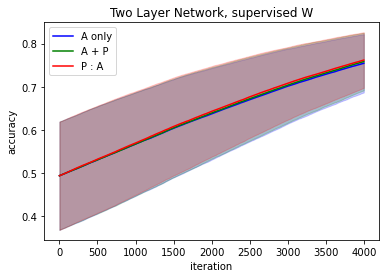

In [14]:
to_draw = [[an_doublel_sw[1][0], "A only", "blue"], [ap_doublel_sw[1][0][:,::10], "A + P", "green"], [pta_doublel_sw[1][0][:,-4000:], "P : A", "red"]]
for data, label, color in to_draw:
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(data_mean, label=label, color=color)
    plt.fill_between(np.arange(len(data_mean)), data_mean-data_std, data_mean+data_std, alpha=0.2, color=color)
plt.legend()
plt.title('Two Layer Network, supervised W')
plt.xlabel('iteration');
plt.ylabel('accuracy');
plt.show()

As we can see, we simply replicate the results of the one-layer model. To see why this is the case, let's watch a video of the hidden representation during a passive-then-active session. 

In [9]:
display(HTML("""<video width="400" height="400" controls><source src="vid/swuv.mp4" type="video/mp4"></video>"""))

What's happening here is that the initial hidden representation is not very separable, so the Hebbian learning of $v$ during the passive sessions doesn't separate the point clouds.

## Supervised W, unsupervised v

The combination of supervised learning for $W$, and unsupervised learning for $\vec v$ works better.

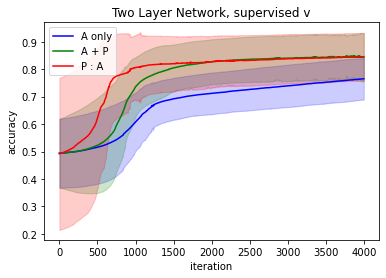

In [6]:
to_draw = [[an_doublel_sv[1][0], "A only", "blue"], [ap_doublel_sv[1][0][:,::10], "A + P", "green"], [pta_doublel_sv[1][0][:,-4000:], "P : A", "red"]]
for data, label, color in to_draw:
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    plt.plot(data_mean, label=label, color=color)
    plt.fill_between(np.arange(len(data_mean)), data_mean-data_std, data_mean+data_std, alpha=0.2, color=color)
plt.legend()
plt.title('Two Layer Network, supervised v')
plt.xlabel('iteration');
plt.ylabel('accuracy');
plt.show()

In this case, passive learning provides a clear benefit. Let's look at another video of a passive-then-active session to understand that.

In [25]:
display(HTML("""<video width="400" height="400" controls><source src="vid/svuw.mp4" type="video/mp4"></video>"""))

As we can see, in this case, the passive training sessions are used to extract the first principal component of the input data onto the hidden layer. This is a useful starting point to do stochastic gradient descent for $\vec v$. 

## Next Steps (TBD)

### Similarity Matching

To elucidate the differences between similarity matching and Hebbian learning, we have to choose a more complex input data distribution. Specifically, in this report, the input space is assumed to be 100-dimensional, and
$$\Sigma = O\, \text{diag}(\underbrace{8\sigma^2, \ldots, 8\sigma^2}_{\times 20}, \underbrace{\sigma^2, \ldots,\sigma^2}_{\times 80})\, O^T,$$
where $O$ is a random orthogonal matrix.

This implies a hierarchy in the principal components of the input: The first 20 columns of $O$ span the higher principal components, while the data in the other 80 directions is more narrowly distributed. The decoding direction $\Delta \vec \mu$ is chosen as
$$\Delta \vec\mu = \alpha\frac{1}{\sqrt{30}}\sum_{i=1}^{30} \vec O_i,$$
where $\vec O_i$ is the $i$-th column vector of $O$ and $\alpha$ is a scalar determining the signal to noise ratio.

## Bimodality

In [22]:
@interact(dis_in=(0, 40000))
def hist(dis_in=0):
    plt.title("Histogram of accuracies during learning for P : A")
    plt.xlabel("Accuracy")
    plt.xlim((0,1))
    plt.hist(np.array(pta_doublel_sv[1][0][:,dis_in]), bins=10)
    plt.show()

interactive(children=(IntSlider(value=0, description='dis_in', max=40000), Output()), _dom_classes=('widget-in…